# Latency Calculations

We consider latency to be the difference in time between data generation and successful data upload to a cloud server. For example, suppose a BLE sensor takes a sample at some time $t_0$. A mule wanders into the range of the BLE sensor at time $t_1 \geq t_0$, successfully identifies and forms a connection with the sensor by time $t_2$ and finishes collecting the data payload from the sensor by time $t_3$. The mule may then go through some metadata obfuscation techniques and finally upload the sensor's data to the cloud by time $t_4$. The latency of the network as experienced by this particular sample is $t_4 - t_0$.

We want to collect metrics on average latency and maximum latency for sensors in our simulated network. In this notebook, we start by considering the time differences of when one mule leaves the range of a sensor and the next mule enters the range of the sensor, which gives us an upper bound for $t_1 - t_0$. We consider how this value changes based on the amount of expected traffic flow and the number of mules in the area.

## Calculate time between successive mule instances

We start by calculating the time between successive mules seen by a particular sensor. If multiple mules are in the range of a sensor at the same time, we just squish them all into the same "mule instance", so we only look at the time periods when the sensor sees absolutely no mules.

In [29]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
# Load data
interact_df = pd.read_csv('prob_data/interactions.csv')
sensor_df = pd.read_csv('prob_data/sensor_metadata.csv')

In [6]:
interact_df.head()

,sensor_id,mule_id,interaction_time,interaction_duration
0,546,0,0.0,1.3
1,697,0,0.0,2.7
2,977,0,0.0,6.7
3,638,0,4.6,3.5
4,624,0,1.2,8.7


In [7]:
sensor_df.head()

,sensor_id,x,y,radius,traffic
0,0,209.619740,591.765392,12.958746,4.0
1,1,126.947178,186.734934,11.276978,6.0
2,2,222.501216,340.385299,15.559558,0.0
3,3,367.453510,567.241528,11.836921,1.0
4,4,256.800432,909.210791,12.419425,0.0


In [27]:
# Identify the times when a sensor does not see any mules
interact_df['interaction_end'] = interact_df['interaction_time'] + interact_df['interaction_duration']

cur_sensor = 0
time_diffs = []

# Only look at a sensor if it has at least two mule interactions, otherwise, the difference does not exist.
smol_interact = interact_df.loc[interact_df['sensor_id'] == cur_sensor]
all_done = len(smol_interact) <= 1

# Start the thing out as the earliest interaction.
if not all_done:
    first_interact = smol_interact.iloc[smol_interact['interaction_time'].argmin()]
    cur_start = first_interact['interaction_time']
    cur_end = first_interact['interaction_end']

while not all_done:
    # Find all interactions that start within the current interaction and extend as necessary
    interaction_done = False
    while not interaction_done:
        new_end = smol_interact.loc[(smol_interact['interaction_time'] >= cur_start) & 
                                    (smol_interact['interaction_time'] <= cur_end)]['interaction_end'].max()
        if new_end == cur_end:
            interaction_done = True
        else:
            cur_end = new_end
    
    # Pick the next interaction to start with. If there are no more interactions, we are done.
    future_interactions = smol_interact.loc[(smol_interact['interaction_time'] > cur_end)]
    if len(future_interactions) <= 0:
        all_done = True
    else:
        next_interaction = future_interactions.iloc[future_interactions['interaction_time'].argmin()]
        time_diffs.append(next_interaction['interaction_time'] - cur_end)
        cur_start = next_interaction['interaction_time']
        cur_end = next_interaction['interaction_end']

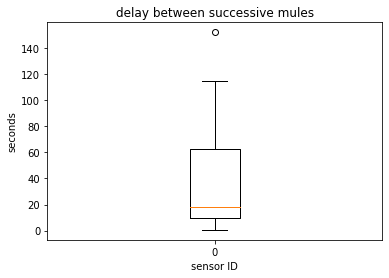

In [34]:
# Visualize our results.
plt.figure()
plt.boxplot(time_diffs, positions=[0])
plt.title('delay between successive mules')
plt.ylabel('seconds')
plt.xlabel('sensor ID')
plt.show()

In [45]:
## Do this for more sensors
num_sensors = 10
num_mules = 100
total_diffs = []
positions = []

# Limit interactions to mules that exist.
smol_interact = interact_df.loc[interact_df['mule_id'] < num_mules]

for cur_sensor in range(num_sensors):
    time_diffs = []

    # Only look at a sensor if it has at least two mule interactions, otherwise, the difference does not exist.
    sensor_interact = smol_interact.loc[smol_interact['sensor_id'] == cur_sensor]
    all_done = len(sensor_interact) <= 1

    # Start the thing out as the earliest interaction.
    if not all_done:
        first_interact = sensor_interact.iloc[sensor_interact['interaction_time'].argmin()]
        cur_start = first_interact['interaction_time']
        cur_end = first_interact['interaction_end']

    while not all_done:
        # Find all interactions that start within the current interaction and extend as necessary
        interaction_done = False
        while not interaction_done:
            new_end = sensor_interact.loc[(sensor_interact['interaction_time'] >= cur_start) & 
                                          (sensor_interact['interaction_time'] <= cur_end)]['interaction_end'].max()
            if new_end == cur_end:
                interaction_done = True
            else:
                cur_end = new_end

        # Pick the next interaction to start with. If there are no more interactions, we are done.
        future_interactions = sensor_interact.loc[(sensor_interact['interaction_time'] > cur_end)]
        if len(future_interactions) <= 0:
            all_done = True
        else:
            next_interaction = future_interactions.iloc[future_interactions['interaction_time'].argmin()]
            time_diffs.append(next_interaction['interaction_time'] - cur_end)
            cur_start = next_interaction['interaction_time']
            cur_end = next_interaction['interaction_end']
    
    # If we have results, we will save and plot them
    if time_diffs:
        total_diffs.append(time_diffs)
        positions.append(cur_sensor)
    # Otherwise, our expected latency is more than an hour (i.e. the duration of our simulation)
    else:
        total_diffs.append([3600])
        positions.append(cur_sensor)

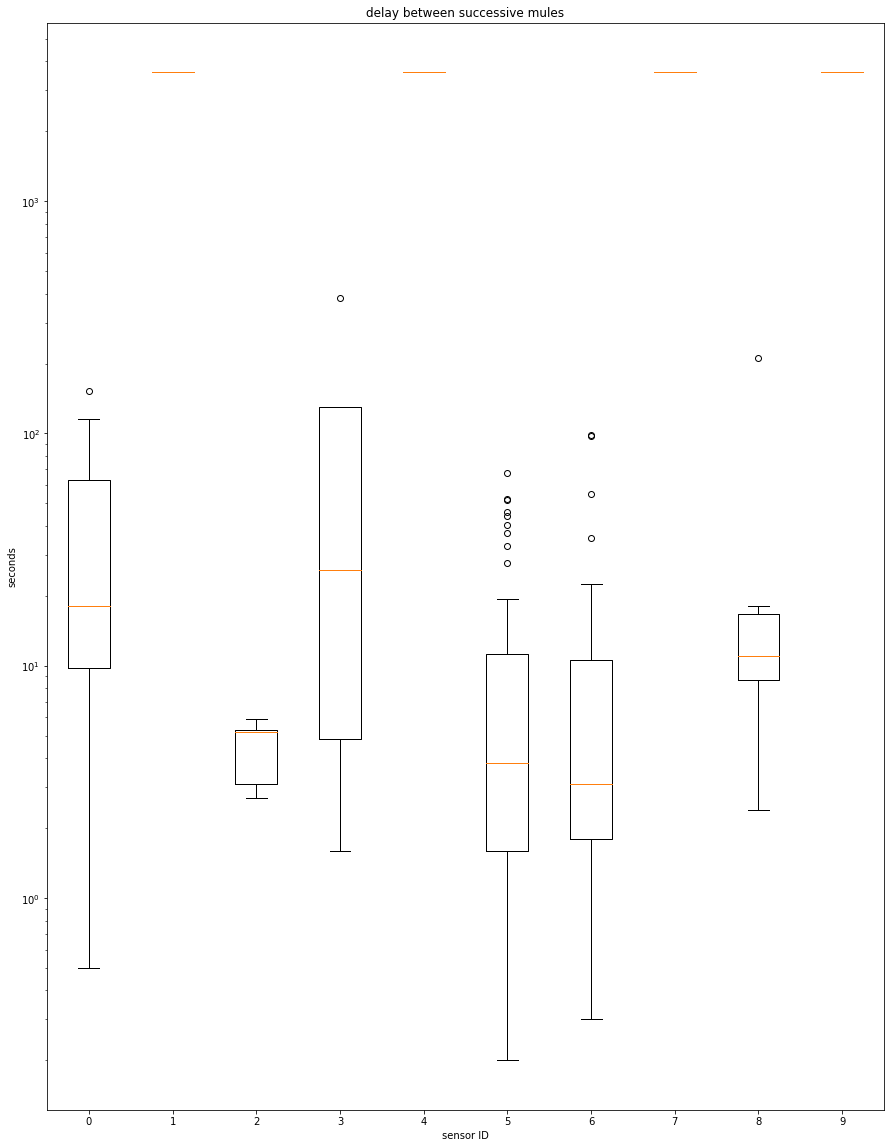

In [46]:
# Visualize our results.
plt.figure(figsize=(15,20))
plt.boxplot(total_diffs, positions=positions)
plt.title('delay between successive mules')
plt.yscale('log') # use log scale to see high and low values better
plt.ylabel('seconds')
plt.xlabel('sensor ID')
plt.show()

## Plot scalability trends

We want to plot average and max latency against expected traffic flow and number of mules. For each sensor that doesn't see two successive mule instances, we assume the latency is just one hour, which may or may not be accurate. We could also filter out all sensors that don't actually see any mules.

In [62]:
# Find max, average, and median latency values with corresponding traffic values
max_latencies = []
med_latencies = []
mean_latencies = []
traffic_vals = []

# Set scalability values.
num_sensors = 1000
num_mules = 100

# Limit interactions to mules that exist.
smol_interact = interact_df.loc[interact_df['mule_id'] < num_mules]

for cur_sensor in range(num_sensors):
    time_diffs = []

    # Only look at a sensor if it has at least two mule interactions, otherwise, the difference does not exist.
    sensor_interact = smol_interact.loc[smol_interact['sensor_id'] == cur_sensor]
    all_done = len(sensor_interact) <= 1

    # Start the thing out as the earliest interaction.
    if not all_done:
        first_interact = sensor_interact.iloc[sensor_interact['interaction_time'].argmin()]
        cur_start = first_interact['interaction_time']
        cur_end = first_interact['interaction_end']

    while not all_done:
        # Find all interactions that start within the current interaction and extend as necessary
        interaction_done = False
        while not interaction_done:
            new_end = sensor_interact.loc[(sensor_interact['interaction_time'] >= cur_start) & 
                                          (sensor_interact['interaction_time'] <= cur_end)]['interaction_end'].max()
            if new_end == cur_end:
                interaction_done = True
            else:
                cur_end = new_end

        # Pick the next interaction to start with. If there are no more interactions, we are done.
        future_interactions = sensor_interact.loc[(sensor_interact['interaction_time'] > cur_end)]
        if len(future_interactions) <= 0:
            all_done = True
        else:
            next_interaction = future_interactions.iloc[future_interactions['interaction_time'].argmin()]
            time_diffs.append(next_interaction['interaction_time'] - cur_end)
            cur_start = next_interaction['interaction_time']
            cur_end = next_interaction['interaction_end']
    
    # If we have no results, set latency time to one hour
    if not time_diffs:
        time_diffs.append(3600)
    
    # Record stats
    max_latencies.append(np.max(time_diffs))
    med_latencies.append(np.median(time_diffs))
    mean_latencies.append(np.mean(time_diffs))
    traffic_vals.append(sensor_df.at[cur_sensor, 'traffic'])

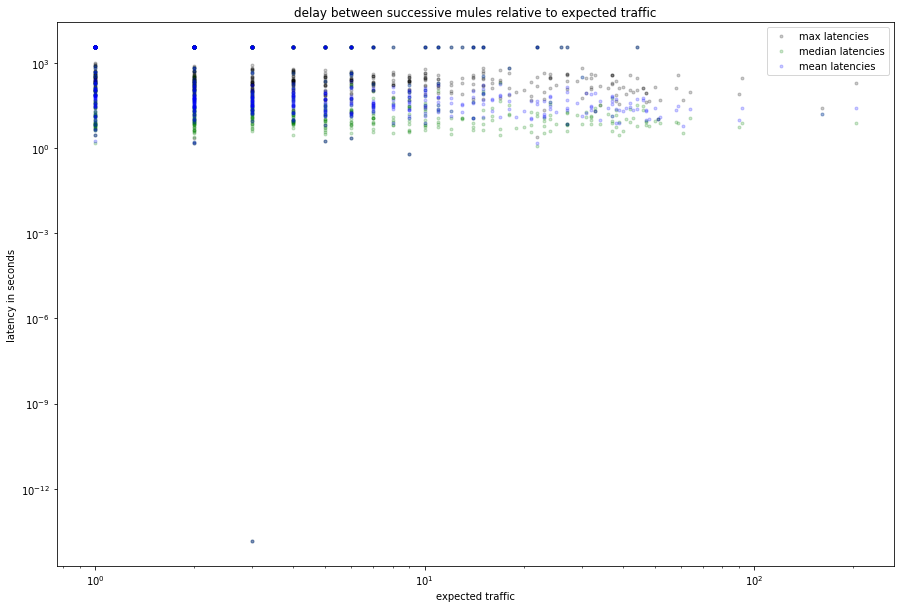

In [78]:
# Plot our results
plt.figure(figsize=(15,10))
plt.loglog(traffic_vals, max_latencies, 'k.', alpha=0.2, label="max latencies")
plt.loglog(traffic_vals, med_latencies, 'g.', alpha=0.2, label="median latencies")
plt.loglog(traffic_vals, mean_latencies, 'b.', alpha=0.2, label="mean latencies")
plt.title('delay between successive mules relative to expected traffic')
plt.xlabel('expected traffic')
plt.ylabel('latency in seconds')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [81]:
# That's pretty gross. Maybe take the average values for each expected traffic?
traffic_set = set(traffic_vals)

np_max = np.array(max_latencies)
np_med = np.array(med_latencies)
np_mean = np.array(mean_latencies)
np_traffic = np.array(traffic_vals)

new_max = []
new_med = []
new_mean = []
new_traffic = []

for traff in traffic_set:
    mask = np_traffic == traff
    new_max.append(np.mean(np_max[mask]))
    new_med.append(np.mean(np_med[mask]))
    new_mean.append(np.mean(np_mean[mask]))
    new_traffic.append(traff)

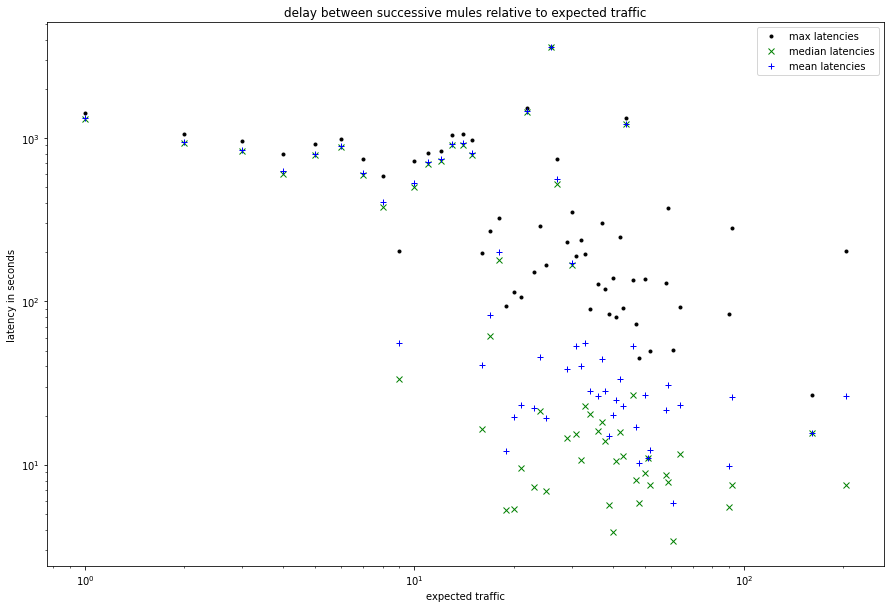

In [96]:
# Plot our results
plt.figure(figsize=(15,10))
plt.loglog(new_traffic, new_max, 'k.', label="max latencies")
plt.loglog(new_traffic, new_med, 'gx', label="median latencies")
plt.loglog(new_traffic, new_mean, 'b+', label="mean latencies")
plt.title('delay between successive mules relative to expected traffic')
plt.xlabel('expected traffic')
plt.ylabel('latency in seconds')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


Alright. The graph is pretty ugly, but there's a general downward trend, which is to be expected, so that's good enough for now. Now let's do a plot of latency against number of mules.

In [101]:
# Calculate how average latency changes as the number of mules increases
nums_mules = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
latencies = []
num_sensors = 1000

for num_mules in nums_mules:
    # Limit interactions to mules that exist.
    smol_interact = interact_df.loc[interact_df['mule_id'] < num_mules]

    mules_time = []
    
    for cur_sensor in range(num_sensors):
        time_diffs = []

        # Only look at a sensor if it has at least two mule interactions, otherwise, the difference does not exist.
        sensor_interact = smol_interact.loc[smol_interact['sensor_id'] == cur_sensor]
        all_done = len(sensor_interact) <= 1

        # Start the thing out as the earliest interaction.
        if not all_done:
            first_interact = sensor_interact.iloc[sensor_interact['interaction_time'].argmin()]
            cur_start = first_interact['interaction_time']
            cur_end = first_interact['interaction_end']

        while not all_done:
            # Find all interactions that start within the current interaction and extend as necessary
            interaction_done = False
            while not interaction_done:
                new_end = sensor_interact.loc[(sensor_interact['interaction_time'] >= cur_start) & 
                                              (sensor_interact['interaction_time'] <= cur_end)]['interaction_end'].max()
                if new_end == cur_end:
                    interaction_done = True
                else:
                    cur_end = new_end

            # Pick the next interaction to start with. If there are no more interactions, we are done.
            future_interactions = sensor_interact.loc[(sensor_interact['interaction_time'] > cur_end)]
            if len(future_interactions) <= 0:
                all_done = True
            else:
                next_interaction = future_interactions.iloc[future_interactions['interaction_time'].argmin()]
                time_diffs.append(next_interaction['interaction_time'] - cur_end)
                cur_start = next_interaction['interaction_time']
                cur_end = next_interaction['interaction_end']

        # If we have no results, set latency time to one hour
        if not time_diffs:
            time_diffs.append(3600)

        # Record stats
        mules_time.append(np.mean(time_diffs))
    
    if not mules_time:
        mules_time.append(3600)
    
    latencies.append(np.mean(mules_time))

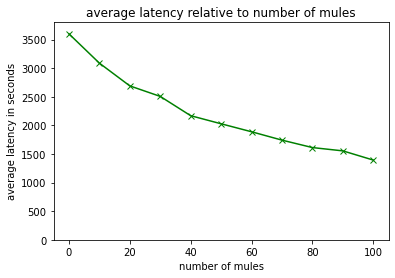

In [111]:
plt.figure()
plt.title("average latency relative to number of mules")
plt.xlabel("number of mules")
plt.ylabel("average latency in seconds")
plt.ylim(0, 3800)
plt.plot(nums_mules, latencies, 'gx-')
plt.show()

Nice nice, that's a good looking graph! Unfortunately, even with 100 mules, the average latency is around 25 minutes. This does consider a lot of sensors that are not even seen by one mule, though, so maybe if we only consider sensors that we actually see, we can get better values? Or if only consider sensors with nonzero expected traffic?

In [114]:
# Calculate how average latency changes as the number of mules increases
nums_mules = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
seen_latencies = []
num_sensors = 1000

# Only consider sensors that we have seen
seen_sensors = interact_df['sensor_id'].unique()

for num_mules in nums_mules:
    # Limit interactions to mules that exist.
    smol_interact = interact_df.loc[interact_df['mule_id'] < num_mules]

    mules_time = []
    
    for cur_sensor in seen_sensors:
        time_diffs = []

        # Only look at a sensor if it has at least two mule interactions, otherwise, the difference does not exist.
        sensor_interact = smol_interact.loc[smol_interact['sensor_id'] == cur_sensor]
        all_done = len(sensor_interact) <= 1

        # Start the thing out as the earliest interaction.
        if not all_done:
            first_interact = sensor_interact.iloc[sensor_interact['interaction_time'].argmin()]
            cur_start = first_interact['interaction_time']
            cur_end = first_interact['interaction_end']

        while not all_done:
            # Find all interactions that start within the current interaction and extend as necessary
            interaction_done = False
            while not interaction_done:
                new_end = sensor_interact.loc[(sensor_interact['interaction_time'] >= cur_start) & 
                                              (sensor_interact['interaction_time'] <= cur_end)]['interaction_end'].max()
                if new_end == cur_end:
                    interaction_done = True
                else:
                    cur_end = new_end

            # Pick the next interaction to start with. If there are no more interactions, we are done.
            future_interactions = sensor_interact.loc[(sensor_interact['interaction_time'] > cur_end)]
            if len(future_interactions) <= 0:
                all_done = True
            else:
                next_interaction = future_interactions.iloc[future_interactions['interaction_time'].argmin()]
                time_diffs.append(next_interaction['interaction_time'] - cur_end)
                cur_start = next_interaction['interaction_time']
                cur_end = next_interaction['interaction_end']

        # If we have no results, set latency time to one hour
        if not time_diffs:
            time_diffs.append(3600)

        # Record stats
        mules_time.append(np.mean(time_diffs))
    
    if not mules_time:
        mules_time.append(3600)
    
    seen_latencies.append(np.mean(mules_time))

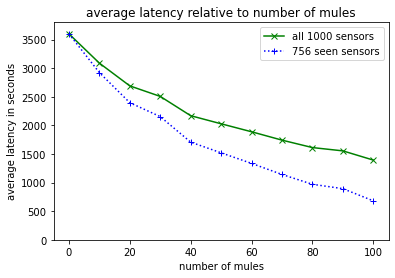

In [117]:
plt.figure()
plt.title("average latency relative to number of mules")
plt.xlabel("number of mules")
plt.ylabel("average latency in seconds")
plt.ylim(0, 3800)
plt.plot(nums_mules, latencies, 'gx-', label='all 1000 sensors')
plt.plot(nums_mules, seen_latencies, 'b+:', label='{} seen sensors'.format(len(seen_sensors)))
plt.legend()
plt.show()

In [121]:
# Calculate how average latency changes as the number of mules increases
nums_mules = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
nonzero_latencies = []
num_sensors = 1000

# Only consider sensors that have nonzero expected traffic
nonzero_sensors = sensor_df.loc[sensor_df['traffic'] > 0]['sensor_id'].unique()

for num_mules in nums_mules:
    # Limit interactions to mules that exist.
    smol_interact = interact_df.loc[interact_df['mule_id'] < num_mules]

    mules_time = []
    
    for cur_sensor in nonzero_sensors:
        time_diffs = []

        # Only look at a sensor if it has at least two mule interactions, otherwise, the difference does not exist.
        sensor_interact = smol_interact.loc[smol_interact['sensor_id'] == cur_sensor]
        all_done = len(sensor_interact) <= 1

        # Start the thing out as the earliest interaction.
        if not all_done:
            first_interact = sensor_interact.iloc[sensor_interact['interaction_time'].argmin()]
            cur_start = first_interact['interaction_time']
            cur_end = first_interact['interaction_end']

        while not all_done:
            # Find all interactions that start within the current interaction and extend as necessary
            interaction_done = False
            while not interaction_done:
                new_end = sensor_interact.loc[(sensor_interact['interaction_time'] >= cur_start) & 
                                              (sensor_interact['interaction_time'] <= cur_end)]['interaction_end'].max()
                if new_end == cur_end:
                    interaction_done = True
                else:
                    cur_end = new_end

            # Pick the next interaction to start with. If there are no more interactions, we are done.
            future_interactions = sensor_interact.loc[(sensor_interact['interaction_time'] > cur_end)]
            if len(future_interactions) <= 0:
                all_done = True
            else:
                next_interaction = future_interactions.iloc[future_interactions['interaction_time'].argmin()]
                time_diffs.append(next_interaction['interaction_time'] - cur_end)
                cur_start = next_interaction['interaction_time']
                cur_end = next_interaction['interaction_end']

        # If we have no results, set latency time to one hour
        if not time_diffs:
            time_diffs.append(3600)

        # Record stats
        mules_time.append(np.mean(time_diffs))
    
    if not mules_time:
        mules_time.append(3600)
    
    nonzero_latencies.append(np.mean(mules_time))

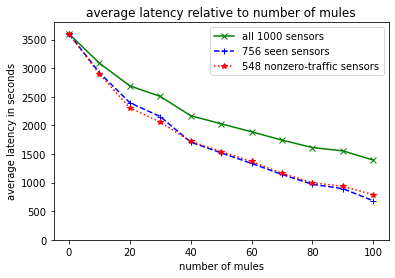

In [123]:
plt.figure()
plt.title("average latency relative to number of mules")
plt.xlabel("number of mules")
plt.ylabel("average latency in seconds")
plt.ylim(0, 3800)
plt.plot(nums_mules, latencies, 'gx-', label='all 1000 sensors')
plt.plot(nums_mules, seen_latencies, 'b+--', label='{} seen sensors'.format(len(seen_sensors)))
plt.plot(nums_mules, nonzero_latencies, 'r*:', label='{} nonzero-traffic sensors'.format(len(nonzero_sensors)))
plt.legend()
plt.show()

## Conclusions

Okee, so let's say a few things about these graphs.

For expected traffic v.s. latency, we get a noisy downward trend. This confirms our idea that places that are generally more populated (heatmap-wise) actually do see mules more often, at least in a simulation where the paths mules take are probabilistically weighted by heatmap values. Since mule paths are random, there's a substantial amount of noise, but that's probably ok. A linear fit could also help demonstrate the negative trend.

For number of mules v.s. average latency, we get a consistent downward trend, which is also to be expected. The `756 seen sensors` only considers sensors that actually show up in the simulation data that we collected. The `548 nonzero-traffic sensors` only considers sensors that are on areas on the heatmap with nonzero heatmap values. Since the random walks could take the simulated mules into areas of the heatmap with heatmap values of zero, we see more sensors in simulation than are on nonzero heatmap values. The fact that the blue line lies along the red line only means that the simulated mules stick reasonably close to the heatmap paths, which is a good sanity check. The fact that the two subsampled lines are below the green line show that unseen sensors skew the latency upward quite a bit.